### Necessary Packages

In [1]:
import numpy as np
import time
import pandas as pd
import sys
import os
import PIL.Image
sys.path.append('../..')
from minisom import MiniSom
from PIL.Image import Image
from tqdm.notebook import tqdm
from definitions import *
from torch.utils.data import Subset
from src.datasets import ISICDataset
from src.utils import seed_everything
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import PIL
from typing import Callable
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.segmentation import chan_vese
from definitions import *

### Reproducibility

In [2]:
SEED = 42
seed_everything(SEED)

### Data Loading

In [3]:
dataset = ISICDataset(
    hdf5_file=os.path.join(ISIS_2024_DIR, 'images.hdf5'),
    metadata_file=os.path.join(ISIS_2024_DIR, 'metadata.csv'),
)

In [4]:
dataset = Subset(dataset, dataset.metadata[dataset.metadata['target'] == 1].index)

### Utility functions

#### Remove the black line that appears on some images

In [5]:
def remove_black_line(image : Image):

    arr = np.array(image)
    mask = arr < 25
    mask = np.all(mask, axis=2)
    coords = np.argwhere(~mask)
    x_min = coords[:, 0].min()
    x_max = coords[:, 0].max()
    y_min = coords[:, 1].min()
    y_max = coords[:, 1].max()

    return image.crop((y_min, x_min, y_max, x_max))

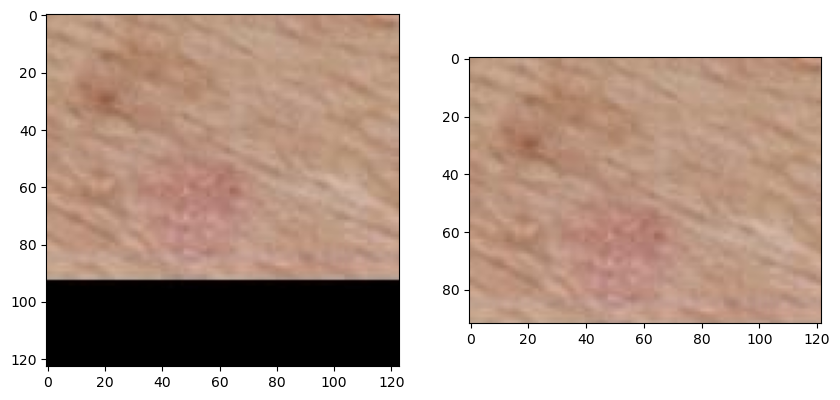

In [6]:
x, y = dataset[255]
img = remove_black_line(x)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(x)
ax[1].imshow(img)

#### A function to test the segmentation method

In [7]:
def test_segmentation_method(image : Image, method, **kwargs):

    mask = method(image, **kwargs)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    roi = image * mask[:, :, None]

    ax[0].imshow(image)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    ax[2].imshow(roi)
    ax[2].set_title('ROI')
    ax[2].axis('off')

In [8]:
test_image = dataset[0][0]

### kohonen neural network segmentation

In [9]:
def khnn_segmentation(image : Image, percentile : float = 10):

    ### Convert the image to numpy array
    x = np.array(image)
    x = x.reshape(-1, 3)
    x = x / 255.0

    ### Train the SOM
    som = MiniSom(64, 64, 3, sigma=1.0, learning_rate=0.5)
    som.train_random(x, num_iteration=1000)

    ### Get the weights
    segmented_image = np.zeros((image.size[1], image.size[0]), dtype=float)
    x = x.reshape(image.size[1], image.size[0], 3)
    for i in range(image.size[1]):
        for j in range(image.size[0]):
            feature_vector = x[i, j, :]
            winner_node = som.winner(feature_vector)
            a,b = winner_node
            weight = som.get_weights()[a, b]
            segmented_image[i, j] = (weight @ feature_vector)

    ### Calculate the  threshold
    threshold = np.percentile(segmented_image, percentile)

    ### Get the binary image
    binary_image = segmented_image < threshold

    ### Preform morphological operations
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)

    ### Preform flood fill
    h, w = binary_image.shape
    mask = np.zeros((h+2, w+2), np.uint8)
    _,_,binary_image,_ = cv2.floodFill(binary_image, mask, (0, 0), 255)
    binary_image = 1 - binary_image

    return binary_image[:-2, :-2]


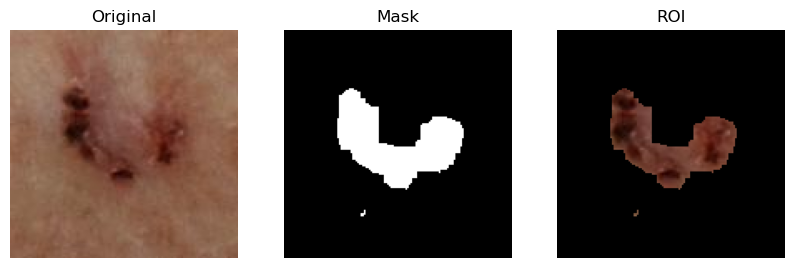

In [10]:
test_segmentation_method(test_image, khnn_segmentation, percentile=10)

### Otsu segmentation

In [34]:
def otsu_thresholding(image : np.ndarray,seed : tuple = (0, 0)):

    ### Convert the image to a numpy array
    image = np.array(image)
    
    ### Convert the image to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    ### Apply Otsu's thresholding
    ret, image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    ### Remove holes with Flood Fill
    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    color = (0,0,0)
    _,_,image,_ = cv2.floodFill(image, mask, seed, color)

    ### Invert the image
    image = 1 - image

    ### Remove background noise
    kernel = np.ones((3,3),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=3)

    ### Remove the border
    image = image[:-2,:-2]

    return image

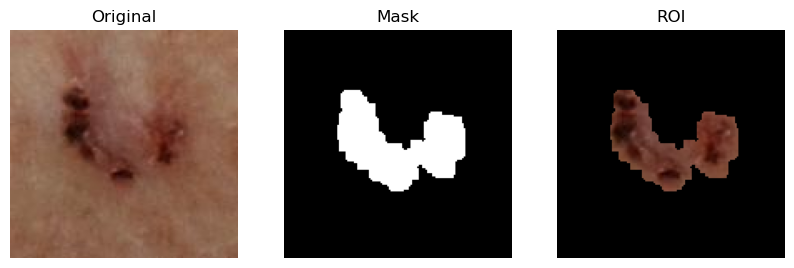

In [35]:
test_segmentation_method(test_image, otsu_thresholding, seed=(0, 0))

### Segmentation with KMeans

In [13]:
def kmeans_segmentation(image : Image, n_clusters : int = 32):

    ### Convert the image to numpy array
    image = np.array(image)
    shape = image.shape

    ### Reshape the image
    image = image.reshape(-1, 3)

    ### Normalize the image
    scaler = StandardScaler()
    image = scaler.fit_transform(image)

    ### Train the KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    kmeans.fit(image)

    ### Normalize the colors
    colors = scaler.inverse_transform(kmeans.cluster_centers_)

    ### Get the segmented image
    segmented_image = colors[kmeans.labels_].reshape(shape).astype(np.uint8)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(segmented_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    segmented_image = segmented_image / 255

    ### Apply morphological operations
    kernel = np.ones((3,3),np.uint8)
    segmented_image = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel, iterations=3)

    ### Apply forward fill
    h, w = segmented_image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    segmented_image = segmented_image.astype(np.uint8)
    color = (0,0,0)
    _,_,segmented_image,_ = cv2.floodFill(segmented_image, mask, (0,0), color)
    segmented_image = 1 - segmented_image

    return segmented_image[:-2,:-2]

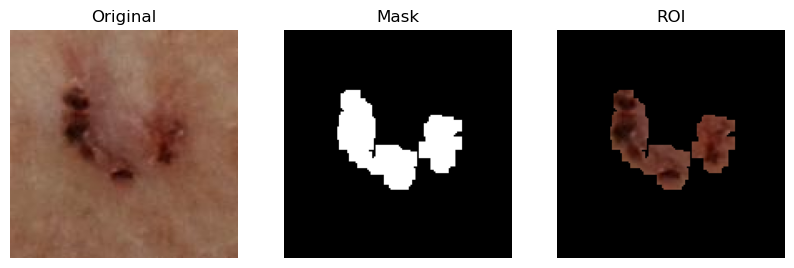

In [14]:
test_segmentation_method(test_image, kmeans_segmentation, n_clusters=2)

#### Segmentation with variance matrix

In [15]:
def variance_matrix(image : Image, ksize : int = 8):

    image = np.array(image)
    
    ### Get the G channel
    image = image[:, :, 1]

    ### Apply Gaussian filter
    image = cv2.GaussianBlur(image, (5, 5), 0)

    ### Calculate the variance matrix
    h, w = image.shape

    variance_matrix = np.zeros((h, w))

    for i in range(h):
        for j in range(w):

            ### Get the window
            x_min = i
            x_max = min(h, i + ksize)
            y_min = j
            y_max = min(w, j + ksize)

            ### Calculate the variance
            variance_matrix[i, j] = np.var(image[x_min:x_max, y_min:y_max])

    ### Calculate the threshold
    threshold = np.std(variance_matrix)

    ### Get the binary image
    binary_image = np.float32(variance_matrix > threshold)

    ### Apply morphological operations
    kernel = np.ones((3,3),np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=3)

    ### Apply forward fill
    h, w = binary_image.shape
    mask = np.zeros((h+2, w+2), np.uint8)
    color = (0,0,0)
    _,_,binary_image,_ = cv2.floodFill(binary_image, mask, (0,0), color)
    binary_image = 1 - binary_image
    binary_image = binary_image[:-2,:-2]

    return binary_image

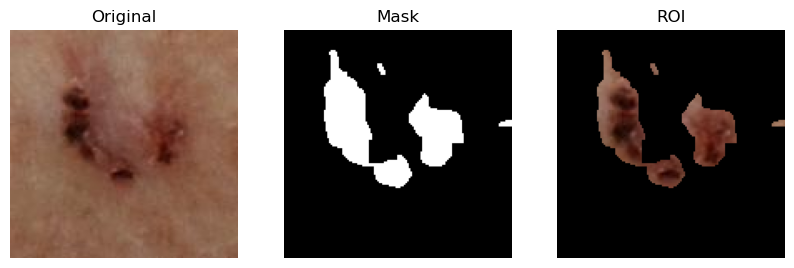

In [16]:
test_segmentation_method(test_image, variance_matrix, ksize=8)

In [17]:
def chan_vese_segmentation(image : Image, mu : float = 0.05, lambda1 : float = 1, lambda2 : float = 1, tol : float = 1e-3, max_num_iter : int = 1000):
    
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    mask = chan_vese(image, mu=mu, lambda1=lambda1, lambda2=lambda2, tol=tol, max_num_iter=max_num_iter)

    return np.int8(mask)

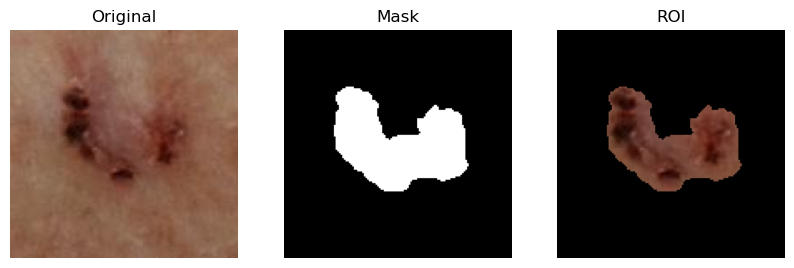

In [18]:
test_segmentation_method(test_image, chan_vese_segmentation, mu=0.05, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=1000)

### Comparing the different methods

In [31]:
def compare(
    images : list[Image],
    methods : list[Callable],
) -> list[float]:
    
    avg_time = pd.Series([0] * len(methods), index=[method.__name__ for method in methods])

    n_images = len(images)
    n_methods = len(methods)

    fig, axes = plt.subplots(n_images, n_methods, figsize=(5 * n_methods, 5 * n_images))

    for i in tqdm(range(n_images)):

        image = images[i]
        image = remove_black_line(image)
        
        for j in range(n_methods):

            method = methods[j]

            start = time.time()
            mask = method(image)
            end = time.time()

            avg_time.iloc[j] += (end - start) / n_images

            roi = image * mask[:, :, None]

            axes[i, j].imshow(roi)
            axes[i, j].set_title(f'{methods[j].__name__}')
            axes[i, j].axis('off')

    return avg_time

  0%|          | 0/10 [00:00<?, ?it/s]

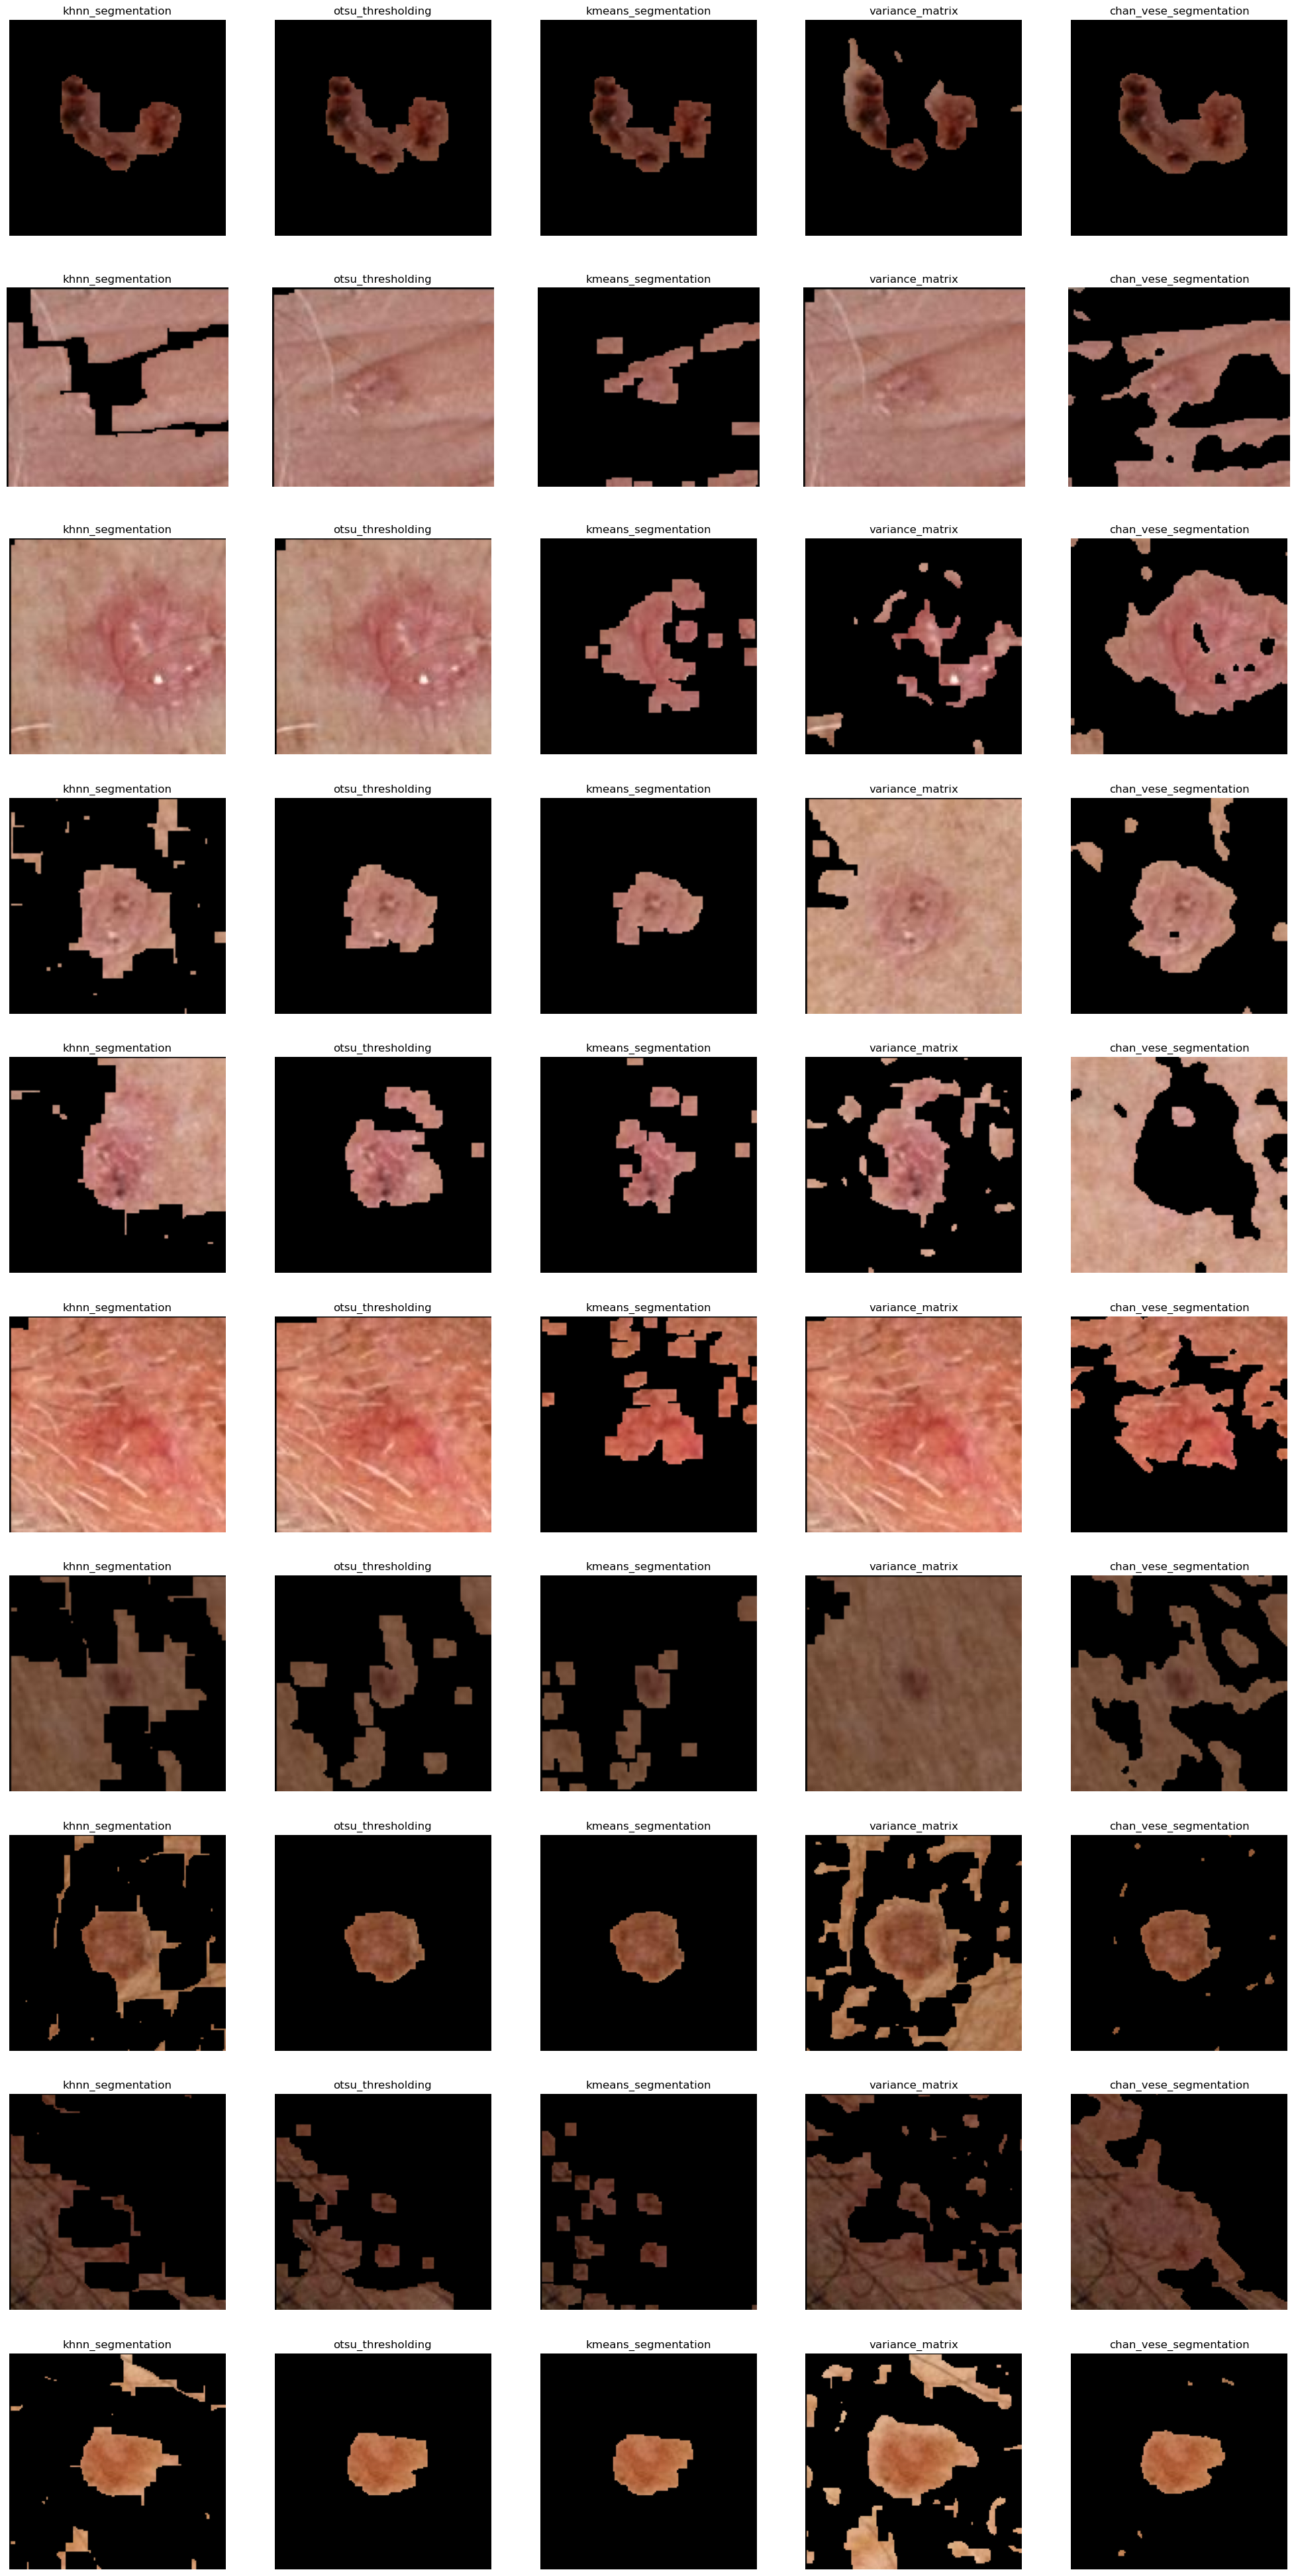

In [32]:
avg_times = compare(
    images=[dataset[i][0] for i in range(10)],
    methods=[
        khnn_segmentation,
        otsu_thresholding,
        kmeans_segmentation,
        variance_matrix,
        chan_vese_segmentation,
    ],
)

- Removing those black lines improves segmentation

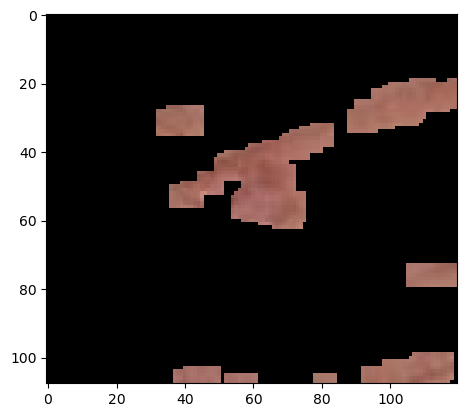

In [21]:
x = dataset[1][0]
x = remove_black_line(x)
mask = kmeans_segmentation(x)
roi = x * mask[:, :, None]
plt.imshow(roi)

/tmp/ipykernel_164126/500165860.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


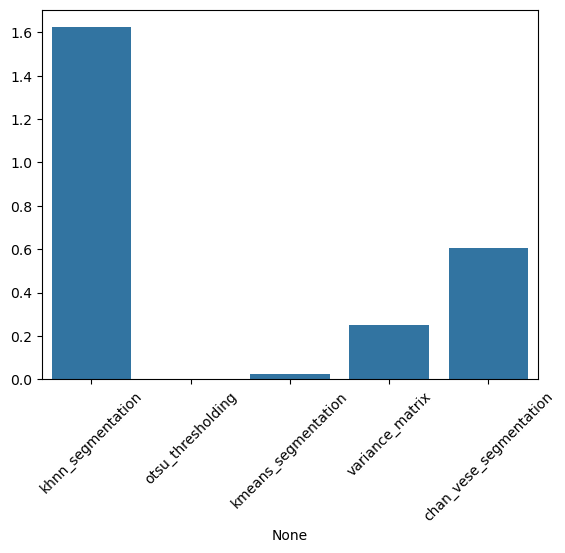

In [22]:
ax = sns.barplot(x=avg_times.index, y=avg_times.values)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

1. KMeans, otsu's and variance matrix are the most solid.
2. chan vese is unusable as it sometimes removes the ROI instead of keeping it.
3. KHNN is good but take a significant computational time.

### Color transfering

- Convert images to LAB space because colors are more independent there.
- Normalize the source image by subtracting its means and dividing it by its standard deviation (channel wise).
- Add the mean of the target image to the normalized image and divide the latter by its standard deviation.
- Convert the image back to RGB.
- Usefull for data augmentation

In [23]:
def color_transfer(source : Image,target : Image):

    ### Convert the images to numpy arrays
    source = np.array(source)
    target = np.array(target)

    ### Convert the images to LAB
    source = cv2.cvtColor(source, cv2.COLOR_RGB2LAB)
    target = cv2.cvtColor(target, cv2.COLOR_RGB2LAB)

    ### Get the mean and std of the source and target
    source_mean, source_std = cv2.meanStdDev(source)
    target_mean, target_std = cv2.meanStdDev(target)

    ### Transfer the color
    for i in range(1,3):
        source[:,:,i] = ((source[:,:,i] - source_mean[i]) * (target_std[i] / source_std[i])) + target_mean[i]

    ### Convert the image back to RGB
    source = cv2.cvtColor(source, cv2.COLOR_LAB2RGB)

    return PIL.Image.fromarray(source)

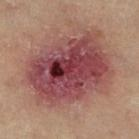

In [24]:
x1, y1 = dataset[147]
x2, y2 = dataset[115]
x1

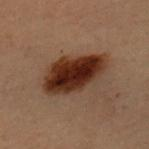

In [25]:
x2

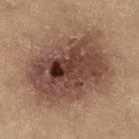

In [26]:
color_transfer(x1, x2)

### Data Augmentation

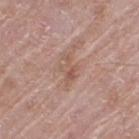

In [27]:
bengin = dataset.dataset[0][0]
bengin

In [28]:
def augment(source : Image, target : Image, method : Callable, common_size : tuple = (128, 128)):

    ### Resize the images
    source = source.resize(common_size)
    target = target.resize(common_size)

    ### Get the mask
    mask = method(source)
    mask = mask[:, :, None]

    ### Calculate the synthetic image
    synthetic = (source * mask) + (target * (1 - mask))
    synthetic = synthetic.astype(np.uint8)

    ### Convert the synthetic image to PIL
    synthetic = PIL.Image.fromarray(synthetic)

    ### Transfer the color
    synthetic = color_transfer(synthetic, target)

    return synthetic

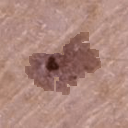

In [29]:
result = augment(x1, bengin, kmeans_segmentation)
result

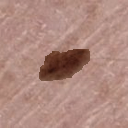

In [30]:
result = augment(x2, bengin, kmeans_segmentation)
result